# Midterm Project

## Problem:

In this project, I will do a sentiment analysis on the earning calls of big firms such as AMZN, F, JPM, JNJ and XOM. In this analysis, we chose companies from a wide variety of field so our analysis is not bias towards one specific field.  


## Implementation:

All of the earning call transcripts data is retrieved from the Motley Fool and downloaded in local folder /data/ as txt files
Now I will pull out those files to run and test them.   

In [1]:
"""
First we load earning data of following companies: 
AMAZON, FORD, JOHNSON JOHNSON, JP MORGAN and EXXON MOBIL
by following format

Dict Earning Data = 
{ Company Names : (Earning Dates) }
"""

earning_date =  {'f': ('2018-4-25','2018-7-25', '2018-10-24', '2019-1-23')
                 ,'amzn' : ('2018-4-26','2018-7-26','2018-10-25', '2019-1-31')
                 , 'jnj' : ('2018-4-17','2018-7-17','2018-10-16','2018-1-22')
                 , 'jpm' : ('2018-4-13','2018-7-13','2018-10-12','2018-1-15')
                 , 'xom' : ('2018-4-26','2018-7-27','2018-11-2','2018-2-1')
                }

earning_date

{'f': ('2018-4-25', '2018-7-25', '2018-10-24', '2019-1-23'),
 'amzn': ('2018-4-26', '2018-7-26', '2018-10-25', '2019-1-31'),
 'jnj': ('2018-4-17', '2018-7-17', '2018-10-16', '2018-1-22'),
 'jpm': ('2018-4-13', '2018-7-13', '2018-10-12', '2018-1-15'),
 'xom': ('2018-4-26', '2018-7-27', '2018-11-2', '2018-2-1')}

We would want to load the data and save it into DataFrame as earning. The index will be the Dates of the earning calls. Other columns would be tickers, and tracscripts of earning calls. 

In [2]:
"""
Loading data
"""

import os 
import numpy as np
import pandas as pd

dir = "data/"
columns = ['date', 'tickers', 'text']
earning = pd.DataFrame(columns=columns)

for file in os.listdir(dir):
    if file.endswith('.txt'):
        file_path = dir + '/' + file
        file_encode = file[:-4].split("_")
        ticker = file_encode[0]
        quater = file_encode[2][1]
        
        '''
          Here we only do analysis on the first quater. To do analysis on other quater, you can 
          change to quater == '2', '3', or '4'
        '''
        if quater == '1':
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()
                date = earning_date[ticker][int(quater)-1]
                earning = earning.append({'date' : date , 'tickers' : ticker.upper(), 'text': text} , ignore_index=True)
            
earning.set_index('date',inplace = True)
earning


,tickers,text
date,,
2018-4-17,JNJ,Operator\n\nGood morning. Welcome to Johnson a...
2018-4-26,AMZN,"Operator\n\nGood day, everyone, and welcome to..."
2018-4-13,JPM,Operator\n\nPlease stand by. We are about to b...
2018-4-26,XOM,"Operator\n\nGood day, everyone, and welcome to..."


Our idea is that we're going to calculate the sentiment score (the higher, the more prositive) of the earning call transcripts and then use them to decide our weight for each those tickers in our portfolio. Now, we will clean our transcript data. 

First, we will lemmatize our text. To be more specific, we will "unpluralize" words in our text. Doing this will help us to do better analysis on each single words in our sentiment analysis. Indeed, we wouldn't care about cases such as "gain" and "gains" since both of them provide same positivity score. 

In [3]:
from textblob import TextBlob
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

earning['text'] = [" ". join([lemmatizer.lemmatize(t) for t in nltk.word_tokenize(text)]) for text in earning['text']]
earning['text'] = [ t.lower() for t in earning['text']]
earning

,tickers,text
date,,
2018-4-17,JNJ,operator good morning . welcome to johnson and...
2018-4-26,AMZN,"operator good day , everyone , and welcome to ..."
2018-4-13,JPM,operator please stand by . we are about to beg...
2018-4-26,XOM,"operator good day , everyone , and welcome to ..."


Also, we did a manual sanity check and saw that there are many words like thank and welcome which do not contribute to the positivity score we are looking for. 

In [4]:
earning['text'] = [t.replace("thank", "") for t in earning['text']]
earning['text'] = [t.replace("welcome", "") for t in earning['text']]
earning

,tickers,text
date,,
2018-4-17,JNJ,operator good morning . to johnson and johnso...
2018-4-26,AMZN,"operator good day , everyone , and to the ama..."
2018-4-13,JPM,operator please stand by . we are about to beg...
2018-4-26,XOM,"operator good day , everyone , and to this ex..."


We will use TextBlob as a tool to analyze sentiment. TextBlob uses a bag-of-word classifier. Indeed, TextBlob does not care about the syntactic structure of the sentences so it does not intesify or negate the sentence sentiment.  This might be one of its disadvantages but the model also provides us the subjectivity score of the sentences. Moreover, the model will run faster than others such as LSTM, or neural network.  

In [5]:
!pip install textblob

In [6]:
#Create a column of textblob scores which include sentiment score and subjectivity score.
earning['sentiment'] = [TextBlob(t).sentiment for t in earning['text']]

#Seperate the subjectivity score and the sentiment score
earning['subjectivity'] = pd.DataFrame([t[1] for t in earning['sentiment'] ], index = earning['sentiment'].index)
earning['sentiment'] = pd.DataFrame([t[0] for t in earning['sentiment']], index = earning['sentiment'].index)


earning

,tickers,text,sentiment,subjectivity
date,,,,
2018-4-17,JNJ,operator good morning . to johnson and johnso...,0.146930,0.394542
2018-4-26,AMZN,"operator good day , everyone , and to the ama...",0.159702,0.399181
2018-4-13,JPM,operator please stand by . we are about to beg...,0.126748,0.390261
2018-4-26,XOM,"operator good day , everyone , and to this ex...",0.134671,0.441840


As you might see, there is no much difference in sentiment score between each earning call. Therefore, we want to add more "attention" on positive words. Indeed, we will do TF-IDF analysis on positive words that are manually picked. TF-IDF to measure the importance of a word in our document by looking at how frequently that word appears in a document and how rare it appears in other documents.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

#List of positive words
pos_words = ['up','nice', 'gain' ,'beat']

#Load them into tfidfvectorizer
vectorizer = TfidfVectorizer(vocabulary=pos_words)

#fit the model into our text
X = vectorizer.fit_transform(earning['text'])
tf_idf = X.toarray()
tf_idf

array([[0.89442719, 0.        , 0.4472136 , 0.        ],
       [0.9912279 , 0.        , 0.13216372, 0.        ],
       [0.98795126, 0.03155336, 0.14819269, 0.03155336],
       [0.9931506 , 0.        , 0.11684125, 0.        ]])

Then after that we update it on the earning board

In [8]:
earning[['up', 'nice', 'gain', 'beat']] = pd.DataFrame(tf_idf, index=earning.index)

earning

,tickers,text,sentiment,subjectivity,up,nice,gain,beat
date,,,,,,,,
2018-4-17,JNJ,operator good morning . to johnson and johnso...,0.146930,0.394542,0.894427,0.000000,0.447214,0.000000
2018-4-26,AMZN,"operator good day , everyone , and to the ama...",0.159702,0.399181,0.991228,0.000000,0.132164,0.000000
2018-4-13,JPM,operator please stand by . we are about to beg...,0.126748,0.390261,0.987951,0.031553,0.148193,0.031553
2018-4-26,XOM,"operator good day , everyone , and to this ex...",0.134671,0.441840,0.993151,0.000000,0.116841,0.000000


Here, we have done on sentiment analysis of the earning calls. Now, we would move on to price analysis of those stocks. We will choose choose the start date of our buy is the last date of those earning calls. Then we will do one-year analysis and compare our portfolio to SPY in terms of performance. 

In [9]:
from tiingo import TiingoClient                       
import quandl                                        
tiingo = TiingoClient({'api_key':'45610b0d975ed195017bdd972a29f989c2adf20a'})
quandl.ApiConfig.api_key = 'vkoFj2M_s9MNdCAVkykU'

# Plotting
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')                         
plt.style.use('ggplot')                               # This will make the plots look nice.
%matplotlib inline

In [10]:
from datetime import datetime  
from datetime import timedelta  
from dateutil.relativedelta import relativedelta

#pick start date and end date of our analysis
start_date = datetime.strptime(max(earning.index), "%Y-%m-%d") + timedelta(days = 1)
end_date = start_date + relativedelta(years=1)  


In [11]:
#Here we do same analysis that we did in class

tickers = [ t for t in earning['tickers']] + ['SPY']
prices  = tiingo.get_dataframe(tickers + ['SHY'], startDate = start_date,endDate = end_date, metric_name='adjClose')

prices
r_daily  = prices.pct_change()
r_annual = prices.iloc[-1]/prices.iloc[0] -1


rx_daily = r_daily.sub(r_daily.SHY, axis = 0)
rx_annual = r_annual.sub(r_annual.SHY, axis = 0)

vol = rx_daily[tickers].std()*252**0.5
rp = rx_annual[tickers]



/home/doppelbeaver/anaconda3/lib/python3.7/site-packages/tiingo/api.py:270: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  prices = pd.concat([prices, df[stock]], axis=1)


In [12]:
risky_assets = risk_return = pd.DataFrame()
risky_assets['RP'] = rp
risky_assets['Vol'] = vol
risky_assets['Sharpe'] = rp/vol
risky_assets['Color'] = 'orange'
risky_assets['Size'] = 100

risky_assets

,RP,Vol,Sharpe,Color,Size
JNJ,0.094952,0.189669,0.500619,orange,100
AMZN,0.210922,0.347859,0.606342,orange,100
JPM,0.046667,0.208160,0.224187,orange,100
XOM,0.049020,0.200872,0.244038,orange,100
SPY,0.092756,0.153277,0.605157,orange,100


In [13]:
riskfree_asset = pd.DataFrame(index=['SHY'])                        
riskfree_asset['RP']     = [0]
riskfree_asset['Vol']    = [0]       
riskfree_asset['Color']  = 'green'
riskfree_asset['Size']   = 100
riskfree_asset

,RP,Vol,Color,Size
SHY,0,0,green,100


In [14]:
all_portfolios = pd.concat([risky_assets, riskfree_asset], sort=False)
all_portfolios

,RP,Vol,Sharpe,Color,Size
JNJ,0.094952,0.189669,0.500619,orange,100
AMZN,0.210922,0.347859,0.606342,orange,100
JPM,0.046667,0.208160,0.224187,orange,100
XOM,0.049020,0.200872,0.244038,orange,100
SPY,0.092756,0.153277,0.605157,orange,100
SHY,0.000000,0.000000,NaN,green,100


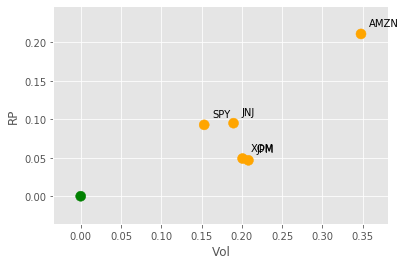

In [15]:
graph = all_portfolios.plot.scatter('Vol','RP', s=all_portfolios.Size, color=all_portfolios.Color)

for t in tickers:                          # loop over t = 'SPY', 'AMZN', 'JNJ', 'JPM', 'XOM'
    x = all_portfolios.loc[t,'Vol'] +0.01  # get x-coordinate from table (+ offset so the labels don't overlap with points)
    y = all_portfolios.loc[t,'RP'] + 0.01         # get y-coordinate from table
    graph.text(x,y,t)                      # add the ticker symbol to the graph



In our analysis, we calculate the final score to identify the weight for each stock based on attributes we collected earlier. To be simple, we consider the each attribute weight to be 1 and sum them up to get the final score. 

In [16]:
earning['score'] = earning.sentiment
earning['score'] = earning.iloc[:, -7:-1].sum(axis=1)


In [17]:
earning

,tickers,text,sentiment,subjectivity,up,nice,gain,beat,score
date,,,,,,,,,
2018-4-17,JNJ,operator good morning . to johnson and johnso...,0.146930,0.394542,0.894427,0.000000,0.447214,0.000000,1.883113
2018-4-26,AMZN,"operator good day , everyone , and to the ama...",0.159702,0.399181,0.991228,0.000000,0.132164,0.000000,1.682275
2018-4-13,JPM,operator please stand by . we are about to beg...,0.126748,0.390261,0.987951,0.031553,0.148193,0.031553,1.716259
2018-4-26,XOM,"operator good day , everyone , and to this ex...",0.134671,0.441840,0.993151,0.000000,0.116841,0.000000,1.686502


To calculate the final weight for each stock, we take the score of that stock divided by the sum of all scores. 

In [18]:
weight = pd.Series([t/sum(earning.score) for t in earning.score], index = earning.tickers)
weight.index = [t.upper() for t in weight.index]


weight

JNJ     0.270246
AMZN    0.241423
JPM     0.246301
XOM     0.242030
dtype: float64

For the sake of ease, we add SPY weight as 0 to calculate the final return and voltality of our portfolio

In [19]:
weight['SPY'] = 0

#Add column weight into our risky assets table
risky_assets['weight'] = pd.DataFrame(weight, index = risky_assets.index)

risky_assets

,RP,Vol,Sharpe,Color,Size,weight
JNJ,0.094952,0.189669,0.500619,orange,100,0.270246
AMZN,0.210922,0.347859,0.606342,orange,100,0.241423
JPM,0.046667,0.208160,0.224187,orange,100,0.246301
XOM,0.049020,0.200872,0.244038,orange,100,0.242030
SPY,0.092756,0.153277,0.605157,orange,100,0.000000


In [20]:
#Calculate the covariance of our portfolio to measure the volatality 

cov = rx_daily[tickers].cov() * 252
cov

,JNJ,AMZN,JPM,XOM,SPY
JNJ,0.035974,0.020305,0.014324,0.016137,0.015527
AMZN,0.020305,0.121006,0.033133,0.030622,0.042907
JPM,0.014324,0.033133,0.043330,0.020875,0.021940
XOM,0.016137,0.030622,0.020875,0.040349,0.020649
SPY,0.015527,0.042907,0.021940,0.020649,0.023494


In [21]:
p_weight = pd.DataFrame(index=['P_W'])                        
p_weight['RP']     = risky_assets.weight.dot(risky_assets.RP)
p_weight['Vol']    = risky_assets.weight.dot(cov).dot(risky_assets.weight) ** 0.5      
p_weight['Sharpe'] = p_weight.RP / p_weight.Vol
p_weight['Color']  = 'blue'
p_weight['Size']   = 50
p_weight

,RP,Vol,Sharpe,Color,Size
P_W,0.09994,0.177052,0.564468,blue,50


In [22]:
all_portfolios = pd.concat([risky_assets, riskfree_asset, p_weight], sort=False)
all_portfolios

,RP,Vol,Sharpe,Color,Size,weight
JNJ,0.094952,0.189669,0.500619,orange,100,0.270246
AMZN,0.210922,0.347859,0.606342,orange,100,0.241423
JPM,0.046667,0.208160,0.224187,orange,100,0.246301
XOM,0.049020,0.200872,0.244038,orange,100,0.242030
SPY,0.092756,0.153277,0.605157,orange,100,0.000000
SHY,0.000000,0.000000,NaN,green,100,NaN
P_W,0.099940,0.177052,0.564468,blue,50,NaN


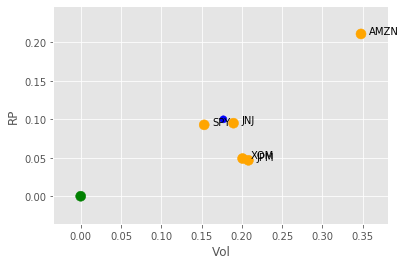

In [23]:
graph = all_portfolios.plot.scatter('Vol','RP', s=all_portfolios.Size, color=all_portfolios.Color)

for t in tickers:                          # loop over t = 'SPY', 'AMZN', 'JNJ', 'JPM', 'XOM'
    x = all_portfolios.loc[t,'Vol']+0.01   # get x-coordinate from table (+ offset so the labels don't overlap with points)
    y = all_portfolios.loc[t,'RP']         # get y-coordinate from table
    graph.text(x,y,t)                      # add the ticker symbol to the graph

As we see here, our portfolio beats SPY by only less than 1% but the votality is higher than SPY by 2%. Indeed, we realize that even a earning call can have a lot of positive words but investor also looks at negative news to decide whether to buy the stock. So, we also do TF-IDF on negative words 

Moreover, the weight of negative words' TF-IDF will be -1 since the more important that negative word is in a earning call, the worse the company performance is in that quater. 

In [24]:
negative_words = ['lose','lost', 'negative' ,'loss', 'decrease']
vectorizer = TfidfVectorizer(vocabulary=negative_words)
X = vectorizer.fit_transform(earning['text'])
tf_idf = X.toarray()
tf_idf *= -1
earning[negative_words] = pd.DataFrame(tf_idf, index=earning.index)

In [25]:
earning

,tickers,text,sentiment,subjectivity,up,nice,gain,beat,score,lose,lost,negative,loss,decrease
date,,,,,,,,,,,,,,
2018-4-17,JNJ,operator good morning . to johnson and johnso...,0.146930,0.394542,0.894427,0.000000,0.447214,0.000000,1.883113,-0.000000,-0.0,-0.955481,-0.295052,-0.000000
2018-4-26,AMZN,"operator good day , everyone , and to the ama...",0.159702,0.399181,0.991228,0.000000,0.132164,0.000000,1.682275,-0.000000,-0.0,-0.000000,-0.000000,-0.000000
2018-4-13,JPM,operator please stand by . we are about to beg...,0.126748,0.390261,0.987951,0.031553,0.148193,0.031553,1.716259,-0.000000,-0.0,-0.198374,-0.980126,-0.000000
2018-4-26,XOM,"operator good day , everyone , and to this ex...",0.134671,0.441840,0.993151,0.000000,0.116841,0.000000,1.686502,-0.219971,-0.0,-0.421213,-0.000000,-0.879882


In [26]:
total = earning.iloc[:, -5:].sum(axis=1)
total

date
2018-4-17   -1.250533
2018-4-26    0.000000
2018-4-13   -1.178501
2018-4-26   -1.521066
dtype: float64

In [27]:
earning['score'] = earning.iloc[:, -6:].sum(axis=1)
earning

,tickers,text,sentiment,subjectivity,up,nice,gain,beat,score,lose,lost,negative,loss,decrease
date,,,,,,,,,,,,,,
2018-4-17,JNJ,operator good morning . to johnson and johnso...,0.146930,0.394542,0.894427,0.000000,0.447214,0.000000,0.632579,-0.000000,-0.0,-0.955481,-0.295052,-0.000000
2018-4-26,AMZN,"operator good day , everyone , and to the ama...",0.159702,0.399181,0.991228,0.000000,0.132164,0.000000,1.682275,-0.000000,-0.0,-0.000000,-0.000000,-0.000000
2018-4-13,JPM,operator please stand by . we are about to beg...,0.126748,0.390261,0.987951,0.031553,0.148193,0.031553,0.537758,-0.000000,-0.0,-0.198374,-0.980126,-0.000000
2018-4-26,XOM,"operator good day , everyone , and to this ex...",0.134671,0.441840,0.993151,0.000000,0.116841,0.000000,0.165436,-0.219971,-0.0,-0.421213,-0.000000,-0.879882


In [28]:
weight = pd.Series([t/sum(earning.score) for t in earning.score], index = earning.tickers)

weight['SPY'] = 0
weight.index = [t.upper() for t in weight.index]

risky_assets['weight'] = pd.DataFrame(weight, index = risky_assets.index)

In [29]:
p_weight = pd.DataFrame(index=['P_W'])                        
p_weight['RP']     = risky_assets.weight.dot(risky_assets.RP)
p_weight['Vol']    = risky_assets.weight.dot(cov).dot(risky_assets.weight) ** 0.5      
p_weight['Sharpe'] = p_weight.RP / p_weight.Vol
p_weight['Color']  = 'blue'
p_weight['Size']   = 50
p_weight

,RP,Vol,Sharpe,Color,Size
P_W,0.148473,0.23605,0.628988,blue,50


In [30]:
all_portfolios = pd.concat([risky_assets, riskfree_asset, p_weight], sort=False)
all_portfolios

,RP,Vol,Sharpe,Color,Size,weight
JNJ,0.094952,0.189669,0.500619,orange,100,0.209599
AMZN,0.210922,0.347859,0.606342,orange,100,0.557405
JPM,0.046667,0.208160,0.224187,orange,100,0.178181
XOM,0.049020,0.200872,0.244038,orange,100,0.054816
SPY,0.092756,0.153277,0.605157,orange,100,0.000000
SHY,0.000000,0.000000,NaN,green,100,NaN
P_W,0.148473,0.236050,0.628988,blue,50,NaN


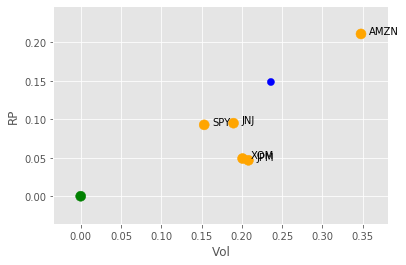

In [31]:
graph = all_portfolios.plot.scatter('Vol','RP', s=all_portfolios.Size, color=all_portfolios.Color)

for t in tickers:                          # loop over t = SPY, EZU, FXI, TLT
    x = all_portfolios.loc[t,'Vol']+0.01   # get x-coordinate from table (+ offset so the labels don't overlap with points)
    y = all_portfolios.loc[t,'RP']         # get y-coordinate from table
    graph.text(x,y,t)                      # add the ticker symbol to the graph

As you can see here, the result is way better. 

## Future works:

1. Attibutes are given and all the smae either 1 or -1. To be generic, we will apply classifer such as linear regression to evaluate the weight of each attributes

2. The result is not robust as it is only tested on 1 quater. We will collect more data and have more thorough analysis. 

3. The strategy is too simple (buy after the earning call and sell after one year).